In [2]:
import librosa # used for sound and musical analysis
import soundfile # handling audio files
import os, glob # access files from folders, glob is used for acessing particular parsed files using filenames
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Feature Extraction
We are extracting three types of features for our audio dataset

In [3]:
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate    
        result=np.array([])
        
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
        
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
            
    return result

In [7]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

emotions_to_be_observed=['happy','neutral','angry']
classes = ['happy','neutral','angry']

In [8]:
def load_data(test_size=0.2):
    i=0
    x,y=[],[]
    for file in glob.glob("/Users/y0y03gi/Projects/Speech-Emotion-Recognition/Emotion data/**/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in emotions_to_be_observed:
            continue
        feature=extract_feature(file)
        x.append(feature)
        y.append(emotion)
        #print(i,emotion)
        i=i+1
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [9]:
X_train,X_test,Y_train,Y_test = load_data(test_size=0.20)

In [10]:
print((X_train.shape[0], X_test.shape[0]))

(384, 96)


In [11]:
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 186


In [13]:
d = {'happy':0,'neutral':1,'angry':2}
y_test = [d[x] for x in Y_test]
y_train = [d[x] for x in Y_train]
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)
print(y_train.shape,y_test.shape)

(384, 3) (96, 3)


In [14]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = ss.fit_transform(X_train)
x_test = ss.transform(X_test)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 30 classes
model = Sequential()
model.add(Dense(186, input_shape=(186,), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

2021-09-01 17:36:23.834882: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
history = model.fit(x_train, y_train, batch_size=64, epochs=150, 
                    validation_data=(x_test, y_test))

2021-09-01 17:36:26.110717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
6/6 [==============================] - 1s 31ms/step - loss: 1.1567 - accuracy: 0.4323 - val_loss: 0.8899 - val_accuracy: 0.5208
Epoch 2/150
6/6 [==============================] - 0s 5ms/step - loss: 0.9215 - accuracy: 0.5651 - val_loss: 0.8395 - val_accuracy: 0.5833
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 0.8589 - accuracy: 0.5677 - val_loss: 0.7930 - val_accuracy: 0.6354
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 0.7954 - accuracy: 0.6354 - val_loss: 0.7386 - val_accuracy: 0.6667
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: 0.7284 - accuracy: 0.6354 - val_loss: 0.6930 - val_accuracy: 0.6875
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 0.7048 - accuracy: 0.7135 - val_loss: 0.6681 - val_accuracy: 0.6667
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.6979 - val_loss: 0.6583 - val_accuracy: 0.6667
Epoch 8/150
6/6 [=========

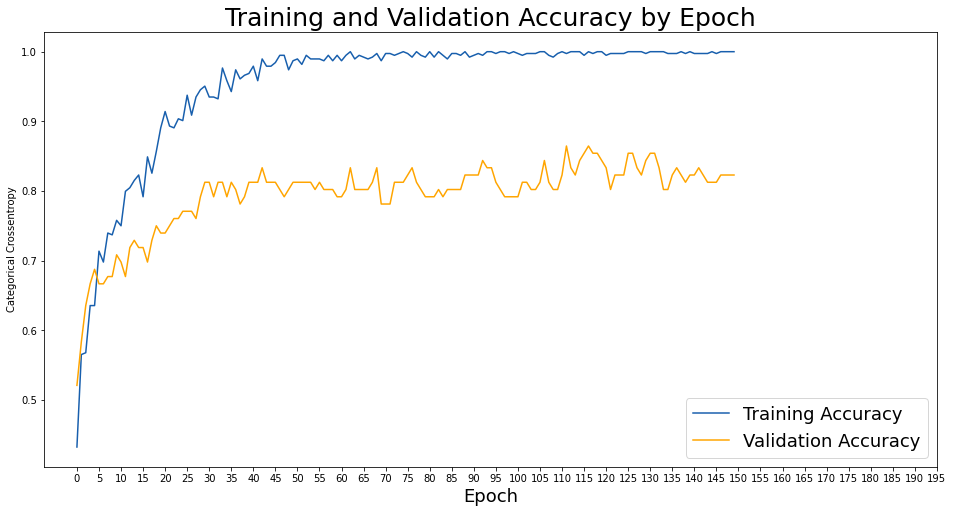

In [17]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Set figure size.
plt.figure(figsize=(16, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 10)
plt.xticks(range(0,200,5), range(0,200,5))
plt.legend(fontsize = 18);

In [18]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)
print(classification_report( y_test_classes, y_pred_classes ))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        38
           1       0.80      0.80      0.80        20
           2       0.87      0.89      0.88        38

    accuracy                           0.82        96
   macro avg       0.82      0.82      0.82        96
weighted avg       0.82      0.82      0.82        96



### Listen to the audios and predict by model

In [ ]:
import speech_recognition as sr
r = sr.Recognizer()

In [19]:
import sounddevice as sd
import soundfile as sf

In [20]:
def playfile(filename):
    data, fs = sf.read(filename, dtype='float32')  
    sd.play(data, fs)
    status = sd.wait()

In [22]:
playfile("Actor2_neutral.wav")

In [23]:
def predict(model,test_input):
    y_pred = model.predict(ss.transform(np.array([extract_feature(test_input)])))
    y_pred_class = y_pred.argmax(axis=-1)
    return classes[y_pred_class[0]]

In [24]:
predict(model, "Actor2_angry.wav")

'angry'